In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# download mnist_dataset to desired directory and split to train, val, test
from make_modular.configs import TRAIN_DATASET_PATH, TEST_DATASET_PATH
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = MNIST(TRAIN_DATASET_PATH, train=True, download=True, transform=transform)
test_ds = MNIST(TEST_DATASET_PATH, train=False, download=True, transform=transform)

# split train_dataset to train and validation dataset
val_percent = .15
val_size = int(val_percent * len(train_ds))
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [3]:
# test our datasets
len(train_ds), len(val_ds), len(test_ds)

(51000, 9000, 10000)

In [4]:
# make dataLoaders 
from make_modular.configs import batch_size

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [5]:
# test dataloaders
images, labels = next(iter(train_dl))

In [6]:
# convert image_tesnsor: (b, c, h, w) --> numpy_array: (b, h, w, c)=(b, 28, 28, 1)
# img = images.numpy().transpose(0, 2, 3, 1)
# plt.imshow(img[0])

In [7]:
# show some images of dataset
from make_modular.utils import show_images
# show_images(images, labels)

In [ ]:
from make_modular.model import MNIST_MODEL_1
from make_modular.utils import print_train_time
from pprint import pprint
# find best lr
from make_modular.utils import find_best_lr

start_time = time.time()

lr_exp_list = find_best_lr(model_class=MNIST_MODEL_1, 
                           n_iter=10,
                           epochs_per_lr=3, 
                           lr_low=-6,
                           lr_high=-3,
                           train_dl=train_dl, 
                           val_dl=val_dl)
end_time = time.time()
total_time = print_train_time(start_time, end_time)

# best lr in list associated with val_loss
best_lr = min(lr_exp_list, key=lambda x: x[list(x.keys())[0]]['val_loss'][-1])
# pprint(f'best_lr : {best_lr}')

lrs = [] # key of dict:the lr
losses_correspond_lr = [] # the test_loss with correspond lr

for dictionary in lr_exp_list:
    min_test_loss_key = min(dictionary, key=lambda k: dictionary[k]['val_loss'][-1])
    lrs.append(min_test_loss_key)
    losses_correspond_lr.append(dictionary[min_test_loss_key]['val_loss'][-1])

In [9]:
# pprint(lr_exp_list)
# pprint(f'best_lr : {best_lr}')

In [10]:
final_res_lr =  []

In [12]:
from make_modular.engine import train
from make_modular.configs import device
from make_modular.model import MNIST_MODEL_1
from make_modular.utils import print_train_time

model = MNIST_MODEL_1()

lr = 5e-2
epochs = 1
project_name = 'MNIST'
experiment_name = f'{model.__class__.__name__},lr:{lr}'

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# configs to save for wandb
hp_configs = {
    'model':model.__class__.__name__,
    'lr':lr,
    'epochs':epochs,
    'device':device
}

start_time = time.time()
results = train(model=model,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                epochs=epochs,
                save_wandb=True,
                project_name=project_name,
                experiment_name=experiment_name,
                hyper_param_config=hp_configs
                )

final_res_lr.append({lr:results})

end_time = time.time()
total_time = print_train_time(start_time, end_time)

epoch 1/1 | train_loss:3.54 | val_loss:2.31 | train_f1_score:0.019 | val_f1_score:0.018


train_acc,▁
train_f1_score,▁
train_loss,▁
val_acc,▁
val_f1_score,▁
val_loss,▁
train_acc,0.10511
train_f1_score,0.01881
train_loss,3.53833
val_acc,0.10133
val_f1_score,0.01816



Train time: 1.673 minutes


In [ ]:
# # find hyperparameters with optuna
# import optuna

# epochs = 2
# loss_fn = nn.CrossEntropyLoss()

# def objective(trial):

#     lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
#     dropout_rate = trial.suggest_float('dropout_rate', .2, .6)
#     model = MNIST_MODEL_1(dropout_rate=dropout_rate)
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#     # optimizer = 
#     results = train(
#         model=model,
#         train_dl=train_dl,
#         val_dl=val_dl,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         device=device,
#         epochs=epochs,
#         save_wandb=False
#     )

#     mean_val_loss = np.mean(results['val_loss'])
    
#     return mean_val_loss

# # start the finding hyper params
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=12)

# # print best params
# best_trial = study.best_trial
# # print(f'best_trial: {study.best_trial}')
# print(f'best_trial.value: {best_trial.values}')
# print(f'best_trial.param: {best_trial.params}')

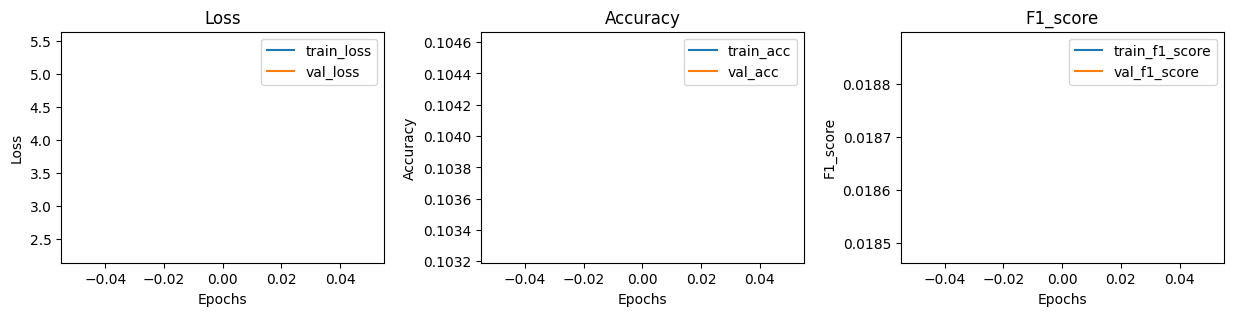

In [32]:
from make_modular.utils import plot_loss_curves
plot_loss_curves(results=results, figsize=(15, 3))

In [ ]:
# save the model
root_model_path = './models/'
model_name = 'mn_model_1.pth'
# # model_name = 'model_2.pth'
# # model_name = 'model_3.pth'
# # model_name = 'model_4.pth'
# # model_name = 'model_5.pth'
# # model_name = 'model_6.pth'
model_path = root_model_path + model_name
torch.save(model.state_dict(), model_path)

In [ ]:
# load the model
model = MNIST_MODEL_1()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# test model on test set
from make_modular.engine import test_one_epoch
test_loss, test_acc, test_f1_score = test_one_epoch(model=model,
                                                    val_dl=test_dl,
                                                    loss_fn=loss_fn,
                                                    device=device)
test_loss, test_acc, test_f1_score

(0.04948953012743028, 0.9841759554140127, 0.9817392659722036)

In [ ]:
# find best lr for models
# write function to dataloaders
# there is a problem with find best lr model should be inside the method 
# ask from gpt how to create new model in each for iterate

In [ ]:
a = [2, 2, 2, 2]
np.mean(a)

2.0